In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

In [2]:
df=pd.read_csv(drv_path+'pattern-drivers_difference_240506.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639 entries, 0 to 2638
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2639 non-null   int64  
 1   NDVI_res    2639 non-null   float64
 2   SIF_res     2639 non-null   float64
 3   TH          2639 non-null   float64
 4   TC          2639 non-null   float64
 5   AGB         2639 non-null   float64
 6   ET          2639 non-null   float64
 7   SOC         2639 non-null   float64
 8   Clay        2639 non-null   float64
 9   Bulk        2639 non-null   float64
 10  LST         2639 non-null   float64
 11  SPEI        2639 non-null   float64
 12  TH_m        2639 non-null   float64
 13  TC_m        2639 non-null   float64
 14  AGB_m       2639 non-null   float64
 15  ET_m        2639 non-null   float64
 16  SOC_m       2639 non-null   float64
 17  Clay_m      2639 non-null   float64
 18  Bulk_m      2639 non-null   float64
 19  LST_m       2639 non-null  

# CatboostClassifier

In [3]:
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import shap
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
ddf=df.copy()
ddf["NDVI_res"][df.NDVI_res<0]=-1
ddf["NDVI_res"][df.NDVI_res>0]=1
ddf["SIF_res"][df.SIF_res<0]=-1
ddf["SIF_res"][df.SIF_res>0]=1

y = ddf['NDVI_res']
x = ddf.drop(['Unnamed: 0','NDVI_res','SIF_res'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=128)

y1 = ddf['SIF_res']
x1 = ddf.drop(['Unnamed: 0','NDVI_res','SIF_res'], axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.3,shuffle=True, random_state=128)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
best_params={'subsample': 1,
 'random_strength': 0.0,
 'min_data_in_leaf': 50,
 'learning_rate': 0.05,
 'l2_leaf_reg': 1,
 'iterations': 2000,
 'early_stopping_rounds': 50,
 'depth': 8,
 'colsample_bylevel': 0.75,
 'border_count': 128,
 'bagging_temperature': 0.0}
best_params1={'subsample': 0.5,
 'random_strength': 1.0,
 'min_data_in_leaf': 50,
 'learning_rate': 0.01,
 'l2_leaf_reg': 1,
 'iterations': 1000,
 'early_stopping_rounds': 30,
 'depth': 10,
 'colsample_bylevel': 1,
 'border_count': 64,
 'bagging_temperature': 0.5}
model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False, **best_params)
#train model
model.fit(X_train, y_train)
model1 = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False, **best_params1)
model1.fit(X_train1, y_train1)

In [5]:
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
explainer1 = shap.TreeExplainer(model1, feature_perturbation="tree_path_dependent")
#SHAP value
shap_values = explainer.shap_values(X_test)
shap_values1 = explainer1.shap_values(X_test1)
#normalized
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
normalized_shap_importance1 = np.abs(shap_values1).mean(axis=0) / np.max(np.abs(shap_values1).mean(axis=0))
#normalized_perm_importance = perm_importance.importances_mean / np.max(perm_importance.importances_mean)
#ascending
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=True)
feature_importance_df1 = pd.DataFrame({'Feature': X_train1.columns, 'SHAP Importance': normalized_shap_importance1})
#feature_importance_df1 = feature_importance_df1.sort_values(by='SHAP Importance', ascending=True)

labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
labels1=list(reversed([i for i in feature_importance_df1['Feature']]))
value1=list(reversed([i for i in feature_importance_df1['SHAP Importance']]))

In [6]:
labels

['LST',
 'SOC',
 'ET',
 'Clay',
 'TH',
 'LST_m',
 'SPEI_m',
 'SPEI',
 'TH_m',
 'Clay_m',
 'ET_m',
 'Bulk',
 'TC',
 'Ele_Dens',
 'SOC_m',
 'AGB',
 'TC_m',
 'AGB_m',
 'Bulk_m']

## Shapley importance

In [7]:
labels_a=['$\Delta$LST','$\Delta$SOC','$\Delta$ET','$\Delta$Clay','$\Delta$Tree_height', 'LST','SPEI','$\Delta$SPEI','Tree height','Clay','ET','$\Delta$Bulk','$\Delta$Tree_cover','Elephant density',
          'SOC','$\Delta$AGB','Tree cover','AGB','Bulk']
len(labels_a)

19

In [8]:
climate_relat=['$\Delta$LST','$\Delta$ET','$\Delta$SPEI','ET','SPEI','LST']
vegetation_relat=['$\Delta$Tree_height','$\Delta$Tree_cover','$\Delta$AGB','Tree height','AGB','Tree cover',]
soil_relat=['$\Delta$Clay','SOC','$\Delta$SOC','Bulk','$\Delta$Bulk','Clay',]
Ele=['Elephant density']

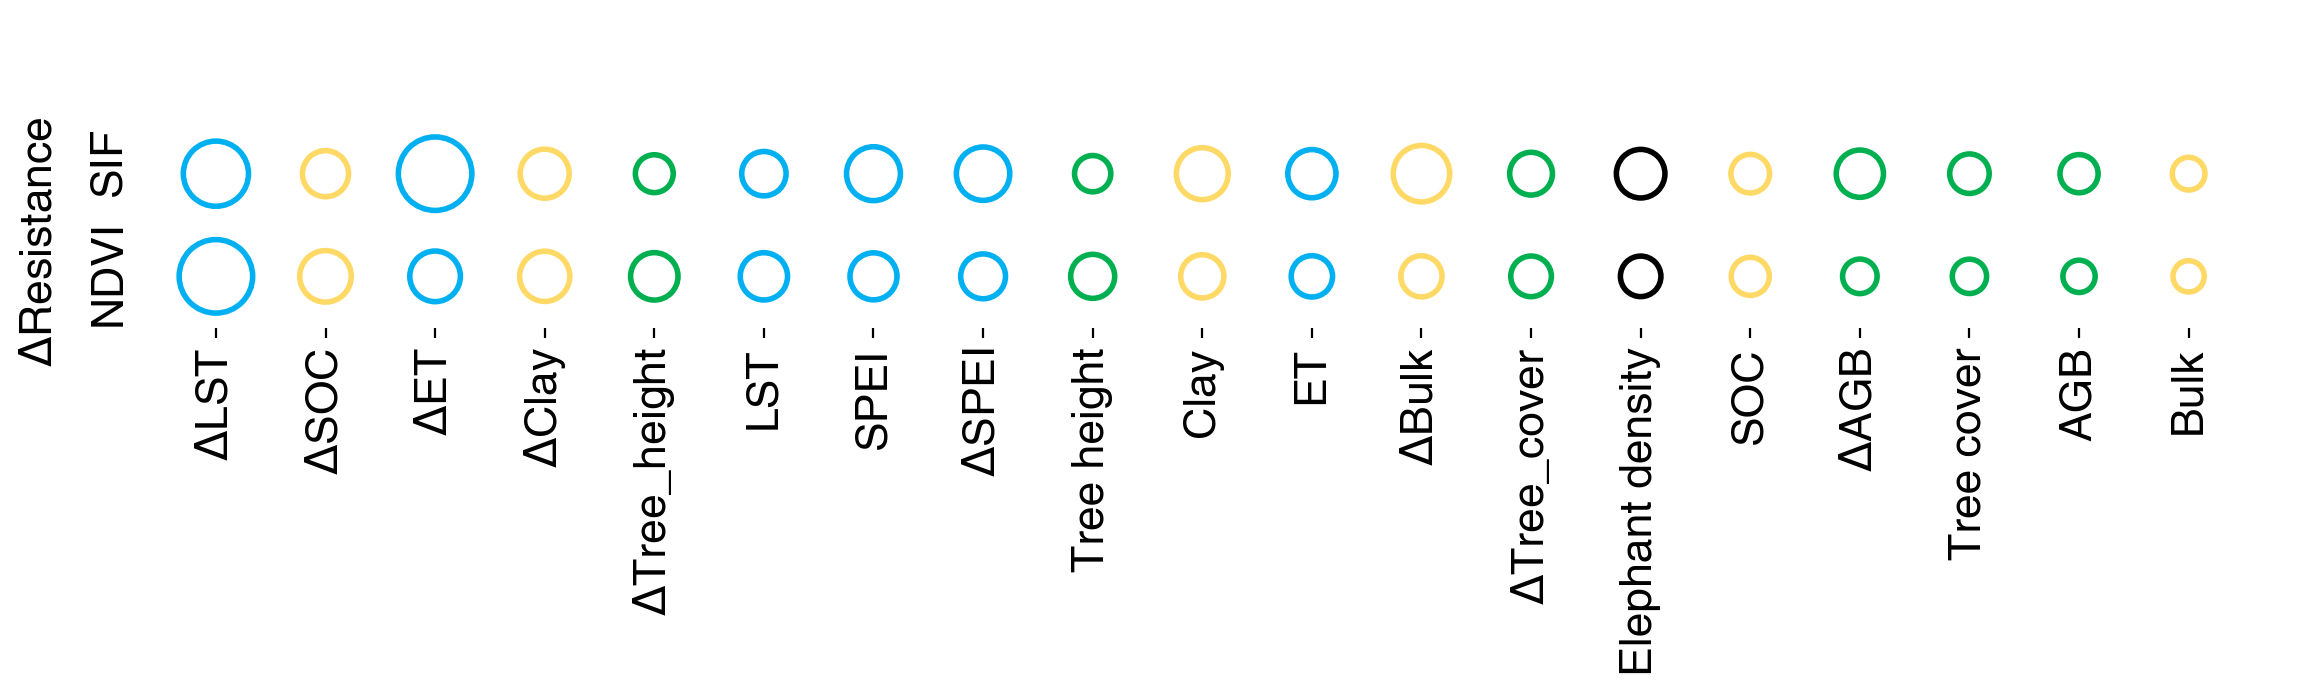

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(14,2), sharex=False,sharey=False)

#cl = np.array([(250,196,152),(133,159,197)])
cl = np.array([(0,176,80),(0,176,240),(255,217,102),(0,0,0)])
cl=cl/255

ax.set_ylim(0,0.6)
ax.set_yticks(np.arange(0,0.6,0.3))
#ax.set_ylim(-0.50,18.5)
x=np.ones((19))*0.1#NDVI
x1=np.ones((19))*0.3#CSIF
y=np.arange(0,19,1)

#CSIF-resistance 从大到小排序，并逐个匹配NDVI-resistance
for i in range(len(value)):
    if labels_a[i] in vegetation_relat:
        col=cl[0]
        ax.scatter( y[i],x[i], s=value[i]*700, color='none',marker='o', edgecolor=col, linewidth=2)
        dt=feature_importance_df1.query('Feature==["{}"]'.format(labels[i])) #从CSIF-resistance importance中由高到低的label匹配NDVI-ressitance
        ax.scatter(y[i],x1[i], s=dt['SHAP Importance']*700, color='none',marker='o', edgecolor=col, linewidth=2)
    elif labels_a[i] in climate_relat:
        col=cl[1]
        ax.scatter( y[i],x[i], s=value[i]*700, color='none',marker='o', edgecolor=col, linewidth=2)
        dt=feature_importance_df1.query('Feature==["{}"]'.format(labels[i])) #从CSIF-resistance importance中由高到低的label匹配NDVI-ressitance
        ax.scatter(y[i],x1[i], s=dt['SHAP Importance']*700, color='none',marker='o', edgecolor=col, linewidth=2)
    elif labels_a[i] in soil_relat:
        col=cl[2]
        ax.scatter( y[i],x[i], s=value[i]*700, color='none',marker='o', edgecolor=col, linewidth=2)
        dt=feature_importance_df1.query('Feature==["{}"]'.format(labels[i])) #从CSIF-resistance importance中由高到低的label匹配NDVI-ressitance
        ax.scatter(y[i],x1[i], s=dt['SHAP Importance']*700, color='none',marker='o', edgecolor=col, linewidth=2)
    elif labels_a[i] in Ele:
        col=cl[3]
        ax.scatter( y[i],x[i], s=value[i]*700, color='none',marker='o', edgecolor=col, linewidth=2)
        dt=feature_importance_df1.query('Feature==["{}"]'.format(labels[i])) #从CSIF-resistance importance中由高到低的label匹配NDVI-ressitance
        ax.scatter(y[i],x1[i], s=dt['SHAP Importance']*700, color='none',marker='o', edgecolor=col, linewidth=2)
    
    #ax.vlines(0.6,-0.5,18.5,lw=1,ls='-',color='gray')
    #ax.hlines(i-0.5+1,0,1.5,lw=1,ls='-',color='gray')
plt.xticks(np.arange(0,19,1),labels_a,rotation=90)
plt.yticks([0.18,0.36],['NDVI','SIF'],rotation=90,fontsize=16)
plt.tick_params(bottom=True, top=False, left=False, right=False)
ax.tick_params(axis='y', which='major', pad=-8)
ax.set_ylabel('$\Delta$Resistance',y=0.28,fontsize=16,labelpad=10)
#ax.text(-0.17,1, '(d)', transform = ax.transAxes,color='black',fontsize=18)
#ax.set_yticks([0.1,0.3])
#ax.set_yticklabels(['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF'],rotation=90,fontsize=14)
#ax.set_ylabel('Partial Dependence',fontsize=16)
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
#ax.set_xlabel('Normalized shap importance',fontsize =18,labelpad=10) # x 轴

## Shapley value distribution

In [10]:
labels_a=['$\Delta$LST','$\Delta$SOC','$\Delta$ET','$\Delta$Clay','$\Delta$Tree_height', 'LST','SPEI','$\Delta$SPEI','Tree height','Clay','ET','$\Delta$Bulk','$\Delta$Tree_cover','Elephant density',
          'SOC','$\Delta$AGB','Tree cover','AGB','Bulk']
len(labels_a)

19

In [11]:
climate_relat=['LST','LST_m','SPEI','SPEI_m','ET','ET_m']
vegetation_relat=['TH','TH_m','TC','TC_m','AGB','AGB_m',]
soil_relat=['SOC','SOC_m','Clay','Clay_m','Bulk','Bulk_m',]
Ele=['Ele_Dens']

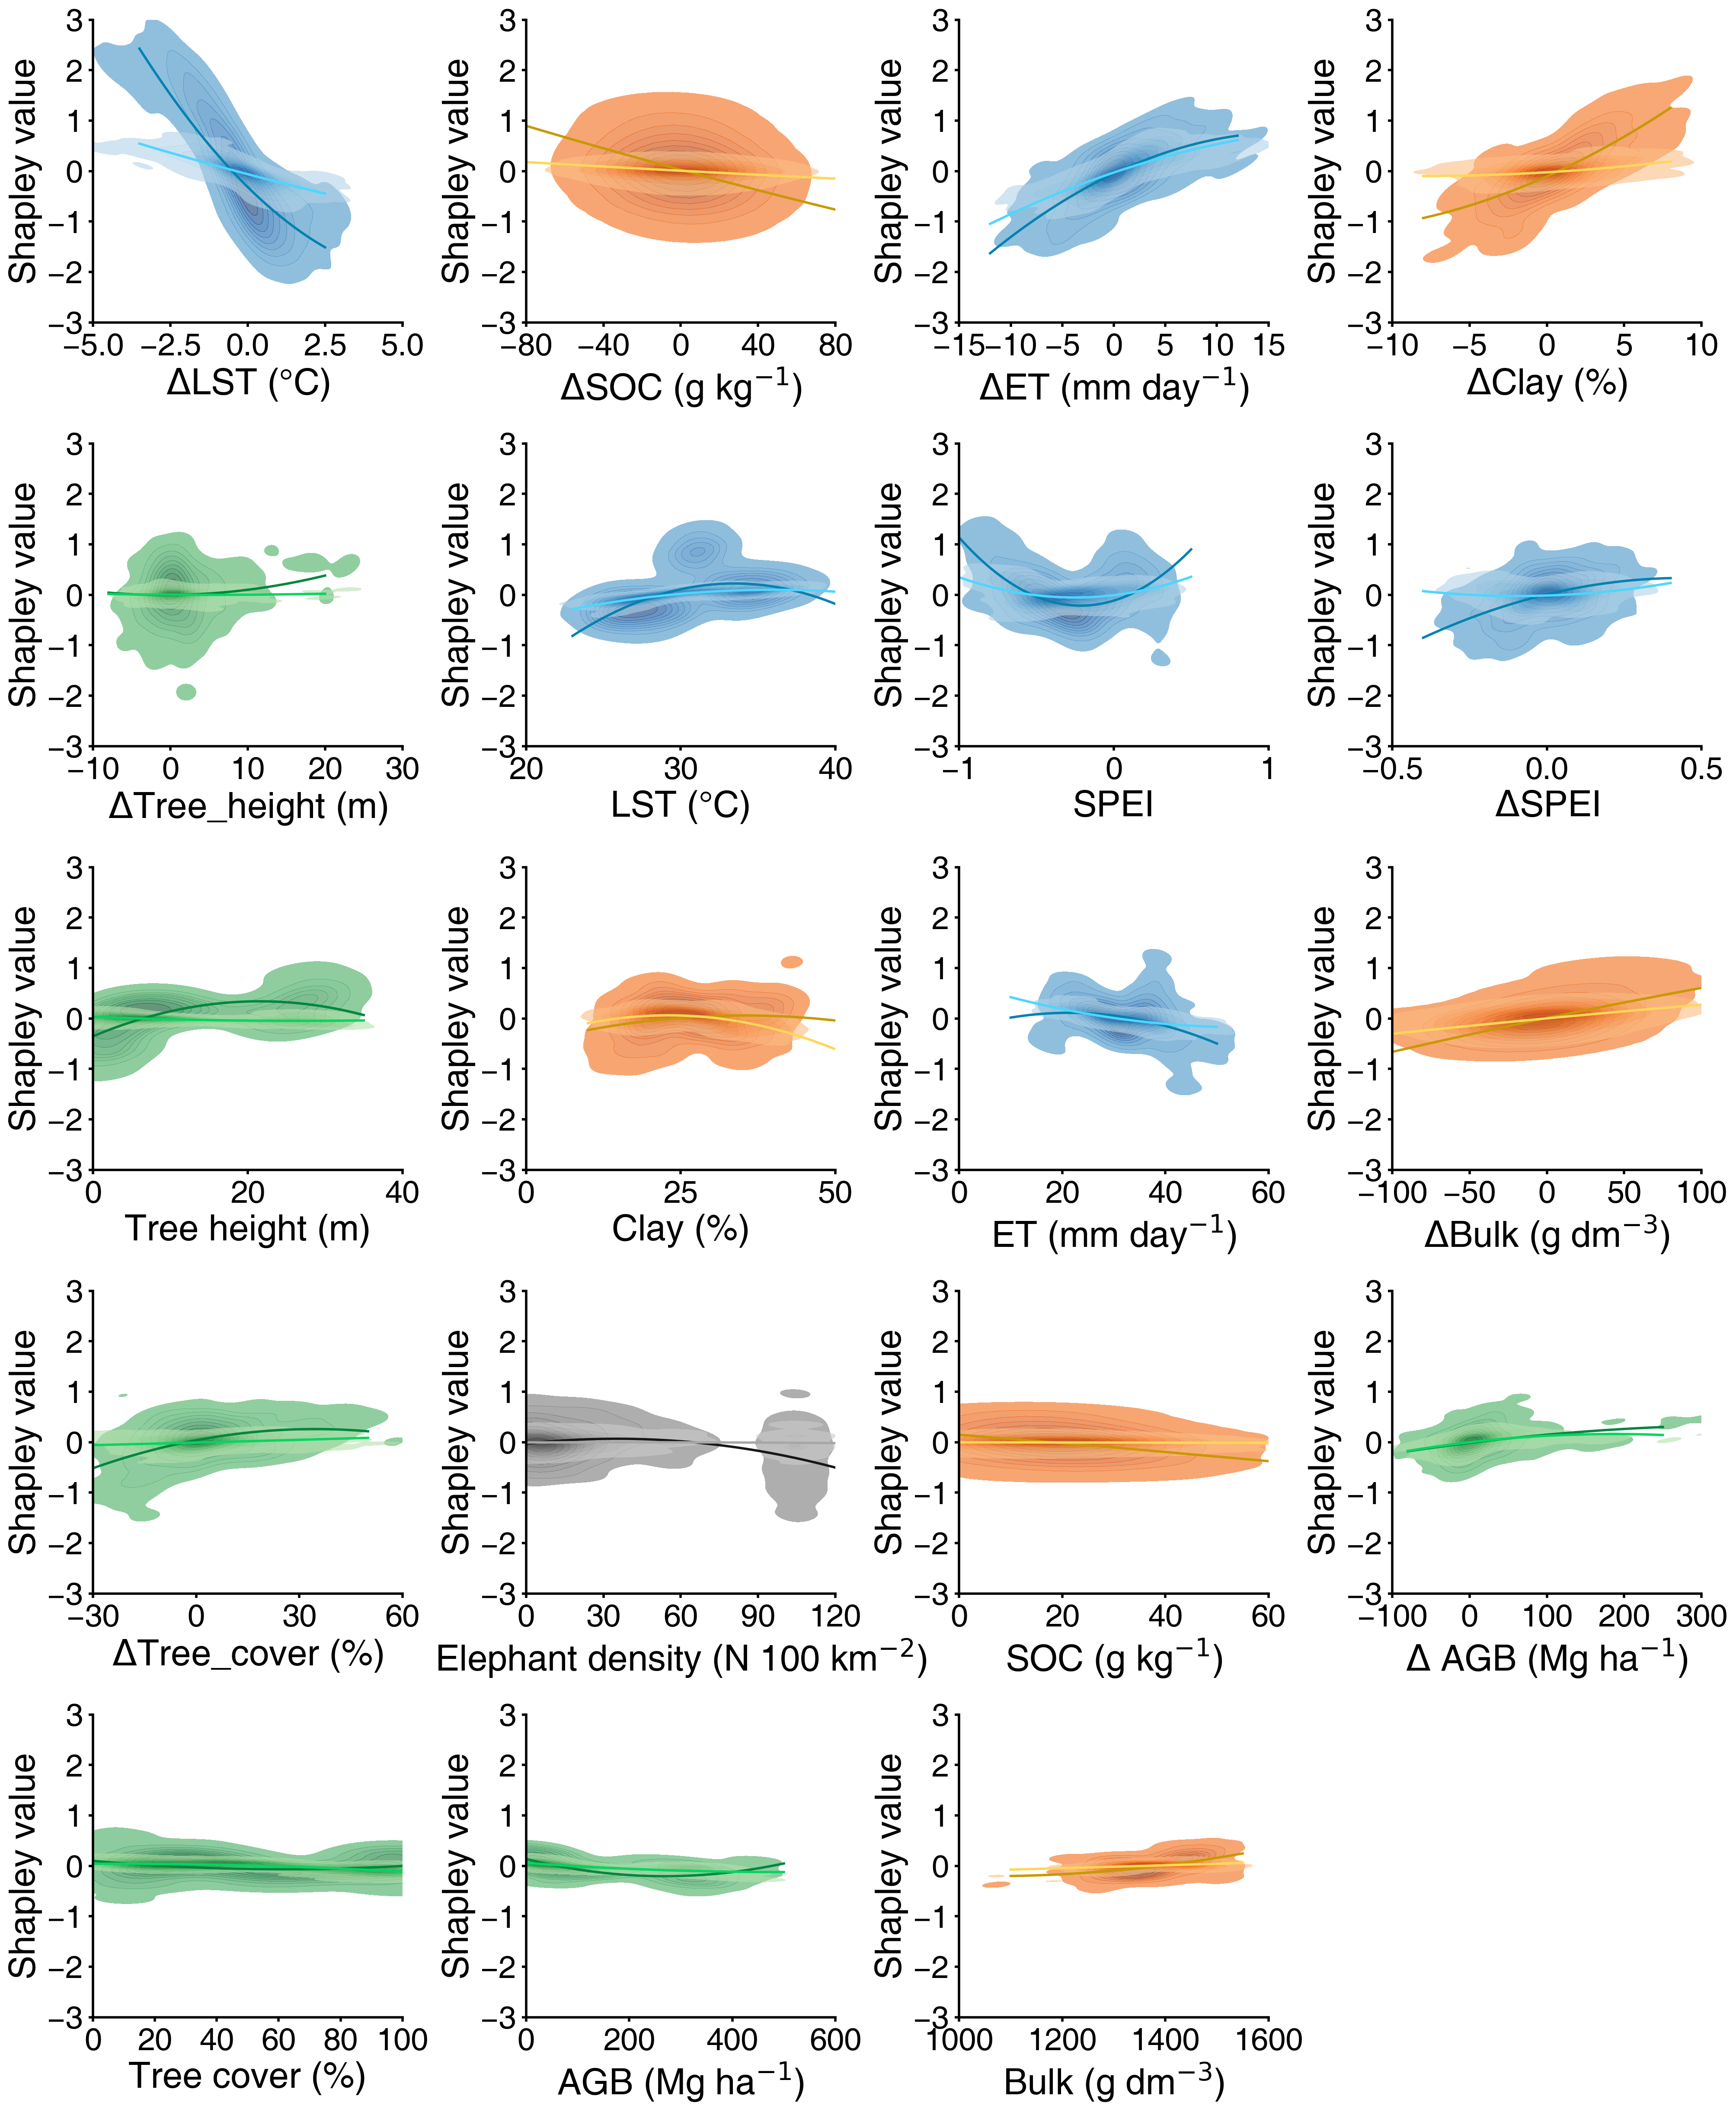

In [12]:
features=['LST','SOC','ET','Clay','TH','LST_m','SPEI_m','SPEI','TH_m','Clay_m','ET_m','Bulk','TC','Ele_Dens','SOC_m','AGB','TC_m','AGB_m','Bulk_m']
from scipy.interpolate import splev, splrep # 数据平滑插值
import matplotlib.colors as colors
import scipy.stats as st
fig = plt.figure(figsize=(24,30)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 2)
#cl = np.array([(77,214,255),(0,214,97),(255,215,87),(255,93,93)])
#cl1= np.array([(0,130,176),(0,134,61),(255,215,87),(204,0,0)])
#cl=cl/255
#cl1=cl1/255
cl_cl1=np.array([(77,214,255)])/255
cl_cl=np.array([(0,130,176)])/255
cl_vg1=np.array([(0,214,97)])/255
cl_vg=np.array([(0,134,61)])/255
cl_so1=np.array([(255,215,87)])/255
cl_so=np.array([(200,152,0)])/255
cl_ele1=np.array([(167,167,167)])/255
cl_ele=np.array([(23,23,23)])/255

xlabel=['$\Delta$LST (°C)','$\Delta$SOC (g kg$^{-1}$)','$\Delta$ET (mm day$^{-1}$)','$\Delta$Clay (%)',
        '$\Delta$Tree_height (m)','LST (°C)','SPEI','$\Delta$SPEI',
        'Tree height (m)','Clay (%)','ET (mm day$^{-1}$)','$\Delta$Bulk (g dm$^{-3}$)',
        '$\Delta$Tree_cover (%)','Elephant density (N 100 km$^{-2}$)','SOC (g kg$^{-1}$)','$\Delta$ AGB (Mg ha$^{-1}$)', 
        'Tree cover (%)','AGB (Mg ha$^{-1}$)','Bulk (g dm$^{-3}$)']
models=[model,model1]
#X_tests=[X_test,X_test1]
x1=[np.linspace(-3.5,2.5,1000),np.linspace(-80,80,1000),np.linspace(-12,12,1000),np.linspace(-8,8,1000),
   np.linspace(-8,20,1000),np.linspace(23,40,1000),np.linspace(-1,0.5,1000),np.linspace(-0.4,0.4,1000),
   np.linspace(0,35,1000),np.linspace(10,50,1000),np.linspace(10,50,1000),np.linspace(-100,100,1000),
   np.linspace(-30,50,1000),np.linspace(0,120,1000),np.linspace(0,60,3),np.linspace(-80,250,1000),
   np.linspace(0,100,1000),np.linspace(0,500,1000),np.linspace(1100,1550,1000)]
x_tick=[np.linspace(-5,5,5),np.linspace(-80,80,5),np.linspace(-15,15,7),np.linspace(-10,10,5),
        np.linspace(-10,30,5),np.linspace(20,40,3),np.linspace(-1,1,3),np.linspace(-0.5,0.5,3),
       np.linspace(0,40,3),np.linspace(0,50,3),np.linspace(0,60,4),np.linspace(-100,100,5),
        np.linspace(-30,60,4),np.linspace(0,120,5),np.linspace(0,60,4),np.linspace(-100,300,5),
       np.linspace(0,100,6),np.linspace(0,600,4),np.linspace(1000,1600,4)]
x_t=[(-5,5),(-80,80),(-15,15),(-10,10),
     (-10,30),(20,40),(-1,1),(-0.5,0.5),
     (0,40),(0,50),(0,60),(-100,100),
    (-30,60),(0,120),(0,60),(-100,300),
    (0,100),(0,600),(1000,1600)]

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
trunc_cl = truncate_colormap(plt.get_cmap("Blues"), 0.6, 1)
trunc_cl1 = truncate_colormap(plt.get_cmap("Blues"), 0.3, 0.8)
trunc_vg = truncate_colormap(plt.get_cmap("Greens"), 0.6, 1)
trunc_vg1 = truncate_colormap(plt.get_cmap("Greens"), 0.3, 0.8)
trunc_so = truncate_colormap(plt.get_cmap("Oranges"), 0.6, 1)
trunc_so1 = truncate_colormap(plt.get_cmap("Oranges"), 0.3, 0.8)
trunc_ele = truncate_colormap(plt.get_cmap("Greys"), 0.6, 1)
trunc_ele1 = truncate_colormap(plt.get_cmap("Greys"), 0.3, 0.8)

for i in range(19):
    ax = plt.subplot(5,4,i+1)  
    if features[i] in climate_relat:
        feature_idx=X_test.columns.get_loc(features[i])
        shap_values_feature = shap_values[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test[features[i]], y=shap_values_feature, cmap=trunc_cl, alpha=0.6, thresh=0.03,fill=True,ax=ax)
        #conf=st.t.interval(alpha= 0.95, df=len(shap_values_feature)-1, loc=np.mean(shap_values_feature), scale=st.sem(shap_values_feature))

        feature_idx1=X_test1.columns.get_loc(features[i])
        shap_values_feature1 = shap_values1[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test1[features[i]], y=shap_values_feature1, cmap=trunc_cl1, alpha=0.6, thresh=0.03,fill=True,ax=ax)

        poly=np.polyfit(X_test[features[i]],shap_values_feature,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value=np.polyval(poly,x1[i])
        yfit=np.polyval(poly,X_test[features[i]])
        ax.plot(x1[i],y_value,color=cl_cl,linewidth=2)

        poly1=np.polyfit(X_test1[features[i]],shap_values_feature1,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value1=np.polyval(poly1,x1[i])
        yfit1=np.polyval(poly1,X_test[features[i]])
        ax.plot(x1[i],y_value1,color=cl_cl1,linewidth=2)
    elif features[i] in vegetation_relat:
        feature_idx=X_test.columns.get_loc(features[i])
        shap_values_feature = shap_values[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test[features[i]], y=shap_values_feature, cmap=trunc_vg, alpha=0.6, thresh=0.03,fill=True,ax=ax)
        #conf=st.t.interval(alpha= 0.95, df=len(shap_values_feature)-1, loc=np.mean(shap_values_feature), scale=st.sem(shap_values_feature))

        feature_idx1=X_test1.columns.get_loc(features[i])
        shap_values_feature1 = shap_values1[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test1[features[i]], y=shap_values_feature1, cmap=trunc_vg1, alpha=0.6, thresh=0.03,fill=True,ax=ax)

        poly=np.polyfit(X_test[features[i]],shap_values_feature,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value=np.polyval(poly,x1[i])
        yfit=np.polyval(poly,X_test[features[i]])
        ax.plot(x1[i],y_value,color=cl_vg,linewidth=2)

        poly1=np.polyfit(X_test1[features[i]],shap_values_feature1,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value1=np.polyval(poly1,x1[i])
        yfit1=np.polyval(poly1,X_test[features[i]])
        ax.plot(x1[i],y_value1,color=cl_vg1,linewidth=2)
    elif features[i] in soil_relat:
        feature_idx=X_test.columns.get_loc(features[i])
        shap_values_feature = shap_values[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test[features[i]], y=shap_values_feature, cmap=trunc_so, alpha=0.6, thresh=0.03,fill=True,ax=ax)
        #conf=st.t.interval(alpha= 0.95, df=len(shap_values_feature)-1, loc=np.mean(shap_values_feature), scale=st.sem(shap_values_feature))

        feature_idx1=X_test1.columns.get_loc(features[i])
        shap_values_feature1 = shap_values1[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test1[features[i]], y=shap_values_feature1, cmap=trunc_so1, alpha=0.6, thresh=0.03,fill=True,ax=ax)

        poly=np.polyfit(X_test[features[i]],shap_values_feature,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value=np.polyval(poly,x1[i])
        yfit=np.polyval(poly,X_test[features[i]])
        ax.plot(x1[i],y_value,color=cl_so,linewidth=2)

        poly1=np.polyfit(X_test1[features[i]],shap_values_feature1,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value1=np.polyval(poly1,x1[i])
        yfit1=np.polyval(poly1,X_test[features[i]])
        ax.plot(x1[i],y_value1,color=cl_so1,linewidth=2)
    elif features[i] in Ele:
        feature_idx=X_test.columns.get_loc(features[i])
        shap_values_feature = shap_values[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test[features[i]], y=shap_values_feature, cmap=trunc_ele, alpha=0.6, thresh=0.03,fill=True,ax=ax)
        #conf=st.t.interval(alpha= 0.95, df=len(shap_values_feature)-1, loc=np.mean(shap_values_feature), scale=st.sem(shap_values_feature))

        feature_idx1=X_test1.columns.get_loc(features[i])
        shap_values_feature1 = shap_values1[:, feature_idx]
        kde_plot = sns.kdeplot(x=X_test1[features[i]], y=shap_values_feature1, cmap=trunc_ele1, alpha=0.6, thresh=0.03,fill=True,ax=ax)

        poly=np.polyfit(X_test[features[i]],shap_values_feature,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value=np.polyval(poly,x1[i])
        yfit=np.polyval(poly,X_test[features[i]])
        ax.plot(x1[i],y_value,color=cl_ele,linewidth=2)

        poly1=np.polyfit(X_test1[features[i]],shap_values_feature1,deg=2)#一元二次方程拟合,,w=count[i]
        #x1=np.linspace(np.min(X_test[features[i]]),np.max(X_test[features[i]]),1000)
        y_value1=np.polyval(poly1,x1[i])
        yfit1=np.polyval(poly1,X_test[features[i]])
        ax.plot(x1[i],y_value1,color=cl_ele1,linewidth=2)

    ax.set_ylim(-3,3)
    ax.set_yticks(np.arange(-3,3.01,1))
    ax.set_xlim(x_t[i])
    ax.set_xticks(x_tick[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(width=2,labelsize=26,pad=5)
    ax.yaxis.set_tick_params(width=2,labelsize=26,pad=5)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    plt.xlabel(xlabel[i],fontsize=30)
    ax.set_ylabel('Shapley value',fontsize=30)
#plt.savefig('./pdpplot_'+i+'.jpg')
#plt.show()